# 11. Variational Auto-Encoder

_Exercise: Train a variational autoencoder on the image dataset of your choice, and use it to generate images. Alternatively, you can try to find an unlabeled dataset that you are interested in and see if you can generate new samples._

## Prepare environment

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow_datasets as tfds

import numpy as np

from keras import layers
import keras

import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [2]:
# Parameters
BATCH_SIZE = 128
INPUT_SHAPE = (28, 28, 1)
LATENT_DIM = 16
EPOCHS = 10

## Prepare dataset

In [3]:
ds, info = tfds.load(
    "mnist",
    split=["train", "test"],
    with_info=True,
    shuffle_files=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.VXKVP1_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.VXKVP1_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
print(info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year

In [5]:
ds_train, ds_test = ds
print(len(list(ds_train)))
print(len(list(ds_test)))

60000
10000


In [6]:
for example in ds_train.take(1):
    image = example["image"]
    print(image.shape)


(28, 28, 1)


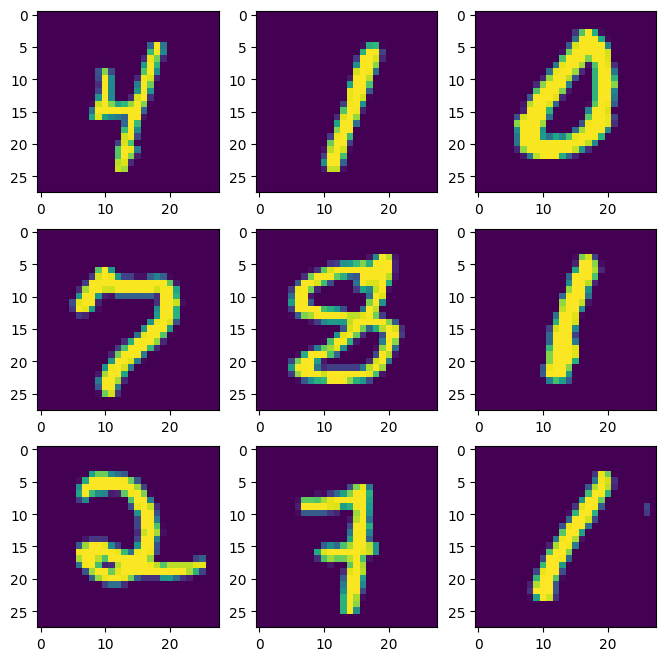

In [7]:
plt.figure(1, figsize=(8,8))
for pos, example in enumerate(ds_train.take(9)):
    plt.subplot(3, 3, pos + 1)
    image = example["image"]
    plt.imshow(image)
plt.show()

In [8]:
AUTO = tf.data.AUTOTUNE

def scale(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

ds_train = (
    ds_train.shuffle(1024)
    .map(lambda X: X["image"])
    .map(scale, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ds_test = (
    ds_test
    .map(lambda X: X["image"])
    .map(scale, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

### Train Variational Auto-Encoder and Generate new images

In [38]:
class BeanVAE(keras.Model):
    def __init__(self, latent_dim):
        super(BeanVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = keras.Sequential([
            layers.Input(shape=INPUT_SHAPE),

            layers.Conv2D(32, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Conv2D(32, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Conv2D(32, 3, activation='relu', strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            layers.Conv2D(64, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Conv2D(64, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Conv2D(64, 3, activation='relu', strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            layers.Conv2D(128, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Conv2D(128, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
        ])

        # Mean and variance layers
        self.dense_mean = layers.Dense(latent_dim, name='mean')
        self.dense_log_var = layers.Dense(latent_dim, name='log_var')

        # Decoder
        self.decoder = keras.Sequential([
            layers.Input(shape=(latent_dim,)),

            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Dense(7 * 7 * 128, activation='relu'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            layers.Reshape((7, 7, 128)),

            layers.Conv2D(128, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Conv2D(128, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Conv2D(64, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Conv2D(64, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Conv2D(32, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            layers.Conv2D(32, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            layers.Conv2DTranspose(INPUT_SHAPE[-1], 3, activation='sigmoid', padding='same')
        ])

    def encode(self, x):
        x = self.encoder(x)
        mean = self.dense_mean(x)
        log_var = self.dense_log_var(x)
        return mean, log_var

    def reparameterize(self, mean, log_var):
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

    def decode(self, z):
        return self.decoder(z)

    def call(self, inputs):
        mean, log_var = self.encode(inputs)
        z = self.reparameterize(mean, log_var)
        reconstructed = self.decode(z)
        return reconstructed, mean, log_var

    def sample(self, n_samples):
        z = tf.random.normal(shape=(n_samples, self.latent_dim))
        return self.decode(z)

In [39]:
def vae_loss_function(inputs, outputs, mean, log_var):
    # Reconstruction loss
    reconstruction_loss = tf.reduce_mean(
        keras.losses.binary_crossentropy(inputs, outputs) * INPUT_SHAPE[0] * INPUT_SHAPE[1] * INPUT_SHAPE[2]
    )

    # KL divergence with clipping for numerical stability
    log_var = tf.clip_by_value(log_var, -10.0, 10.0)  # Prevent extreme values

    # KL divergence
    kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mean) - tf.exp(log_var))

    # Apply additional check for NaN/Inf values
    total_loss = reconstruction_loss + 3 * kl_loss

    print(f"KL Loss: {kl_loss}")

    return tf.debugging.check_numerics(total_loss, "Loss is NaN or Inf")

In [40]:
@tf.function
def train_step(model, optimizer, x):
    with tf.GradientTape() as tape:
        # Forward pass
        reconstructed, mean, log_var = model(x)

        # Compute loss
        loss = vae_loss_function(x, reconstructed, mean, log_var)

    # Compute gradients
    gradients = tape.gradient(loss, model.trainable_variables)

    for g, v in zip(gradients, model.trainable_variables):
        if g is not None:
            tf.debugging.check_numerics(g, f"Gradient for {v.name} is NaN/Inf")
            g = tf.clip_by_norm(g, 5.0)  # Clip gradients by global norm

    # Apply gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [41]:
def visualize_reconstructions(model, images, epoch):
    n = 10
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i])
        plt.title("Original")
        plt.axis("off")

        # Display reconstruction
        img = np.expand_dims(images[i], axis=0)
        reconstruction, _, _ = model(img)
        reconstruction = reconstruction.numpy()[0]

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstruction)
        plt.title("Reconstructed")
        plt.axis("off")

    plt.savefig(f"reconstructions_epoch_{epoch+1}.png")
    plt.close()

In [42]:
def visualize_generated_samples(model, n_samples, epoch):
    generated_images = model.sample(n_samples).numpy()

    plt.figure(figsize=(20, 4))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.title("Generated")

    plt.savefig(f"generated_samples_epoch_{epoch+1}.png")
    plt.close()

In [43]:
model = BeanVAE(LATENT_DIM)
model.summary(expand_nested=True)

Model: "bean_vae_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_14 (Sequential)           │ (None, 256)                 │       3,680,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2d_98 (Conv2D)              │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ batch_normalization_147         │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ leaky_re_lu_147 (LeakyReLU)     │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2d_99 (Conv2D)              │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ batch_normalization_148         │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ leaky_re_lu_148 (LeakyReLU)     │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2d_100 (Conv2D)             │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ batch_normalization_149         │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ leaky_re_lu_149 (LeakyReLU)     │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2d_101 (Conv2D)             │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ batch_normalization_150         │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ leaky_re_lu_150 (LeakyReLU)     │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2d_102 (Conv2D)             │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ batch_normalization_151         │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ leaky_re_lu_151 (LeakyReLU)     │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2d_103 (Conv2D)             │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ batch_normalization_152         │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,544,833 (28.78 MB)

 Trainable params: 7,527,041 (28.71 MB)

 Non-trainable params: 17,792 (69.50 KB)

In [44]:
def train_vae(train_dataset, val_dataset, model_save_path="bean_vae_model.weights.h5"):
    # Create model and optimizer
    model = BeanVAE(LATENT_DIM)
    optimizer = keras.optimizers.Adam(learning_rate=1e-4)

    # Training loop
    print("Starting training...")
    loss_history = []
    val_loss_history = []

    for epoch in range(EPOCHS):
        # Training
        epoch_loss = 0
        num_batches = 0

        for batch in train_dataset:
            loss = train_step(model, optimizer, batch)
            epoch_loss += loss
            num_batches += 1

        epoch_loss /= num_batches
        loss_history.append(epoch_loss)

        # Validation
        val_epoch_loss = 0
        val_num_batches = 0

        for val_batch in val_dataset:
            val_reconstructed, val_mean, val_log_var = model(val_batch)
            val_loss = vae_loss_function(val_batch, val_reconstructed, val_mean, val_log_var)
            val_epoch_loss += val_loss
            val_num_batches += 1

        val_epoch_loss /= val_num_batches
        val_loss_history.append(val_epoch_loss)

        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}")

        # Generate and save some example reconstructions
        if (epoch + 1) % 5 == 0 or epoch == 0:
            visualize_reconstructions(model, list(tfds.as_numpy(ds_test.take(1)))[0][:10], epoch)
            visualize_generated_samples(model, 10, epoch)

    # Save the model
    model.save_weights(model_save_path)

    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('VAE Training and Validation Loss')
    plt.legend()
    plt.savefig('vae_loss_curves.png')
    plt.close()

    return model, loss_history, val_loss_history

In [45]:
model, loss_history, val_loss_history = train_vae(ds_train, ds_test)

Starting training...
KL Loss: Tensor("mul_3:0", shape=(), dtype=float32)
KL Loss: Tensor("mul_3:0", shape=(), dtype=float32)
KL Loss: Tensor("mul_3:0", shape=(), dtype=float32)
KL Loss: 1.771177053451538
KL Loss: 1.79527747631073
KL Loss: 1.761091709136963
KL Loss: 1.767817497253418
KL Loss: 1.8197015523910522
KL Loss: 1.7450214624404907
KL Loss: 1.756748914718628
KL Loss: 1.7535301446914673
KL Loss: 1.7487890720367432
KL Loss: 1.8350518941879272
KL Loss: 1.7664259672164917
KL Loss: 1.7274127006530762
KL Loss: 1.6893938779830933
KL Loss: 1.7162176370620728
KL Loss: 1.7352837324142456
KL Loss: 1.7801849842071533
KL Loss: 1.7292914390563965
KL Loss: 1.7335137128829956
KL Loss: 1.7262229919433594
KL Loss: 1.6998529434204102
KL Loss: 1.7621936798095703
KL Loss: 1.7737016677856445
KL Loss: 1.7327582836151123
KL Loss: 1.7296156883239746
KL Loss: 1.7651968002319336
KL Loss: 1.7025940418243408
KL Loss: 1.7268919944763184
KL Loss: 1.754048466682434
KL Loss: 1.793033480644226
KL Loss: 1.71640431

In [46]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

encoded_imgs = model.encoder(x_test)

In [47]:
# 3. Perform clustering on the latent space
n_clusters = len(np.unique(y_test))  # Assuming the number of clusters equals the number of classes
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(encoded_imgs)

# 4. Compute the ARI
ari_score = adjusted_rand_score(y_test, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari_score}")

Adjusted Rand Index (ARI): 0.4969632014984208


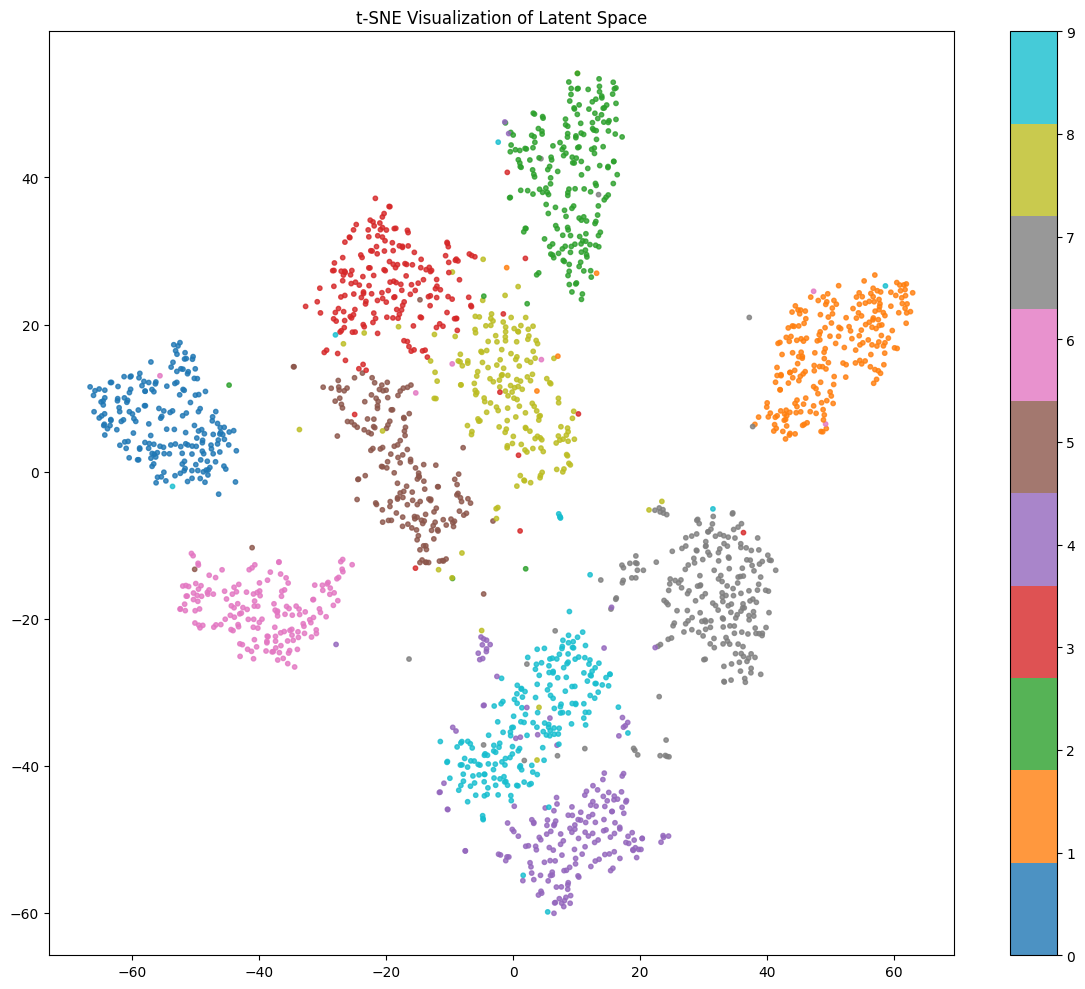

In [54]:
# Function for latent space exploration
def visualize_latent_space(vae, x_test, y_test, n_samples=2000):
    from sklearn.manifold import TSNE

    # Sample random test points
    indices = np.random.choice(len(x_test), n_samples, replace=False)
    samples = x_test[indices]
    labels = y_test[indices]

    # Encode to latent space
    x = vae.encoder(samples)
    mean = vae.dense_mean(x)

    # Dimensionality reduction with t-SNE
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
    z_tsne = tsne.fit_transform(mean)

    # Plot
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=labels,
                cmap='tab10', s=10, alpha=0.8)
    plt.colorbar(scatter, ticks=range(10))
    plt.title("t-SNE Visualization of Latent Space")
    plt.tight_layout()
    plt.show()

# Visualize latent space
visualize_latent_space(model, x_test, y_test)